In [2]:
import pickle as pkl
import numpy as np

X = pkl.load(open('./data/X_processed.pkl', 'rb'))
y = pkl.load(open('./data/y_processed.pkl', 'rb'))

print(X.shape, y.shape)

((6502, 3, 12), (6502,))


In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

training_size = 6000

X_train = X[:training_size]
y_train = y[:training_size]

X_test = X[training_size:]
y_test = y[training_size:]

X_train = X_train.reshape((X_train.shape[0], -1))
X_test = X_test.reshape((X_test.shape[0], -1))

classifier = RandomForestClassifier()
y_pred = classifier.fit(X_train, y_train).predict(X_test)

accuracy_score(y_test, y_pred)

0.92231075697211151

In [4]:
noise = np.random.normal(0, 1, 600)
plt.hist(noise, bins=30)
print(np.where(abs(noise)<0.01))

NameError: name 'plt' is not defined

In [33]:
#public - acgan_200_0.0002_100
#privatenoacount - ea2.0_0.0001_200_0.0002_100
#private

#directory = './output/2.0_0.001_200_0.002_100/'
directory = './output/' + 'privatenoaccount/'

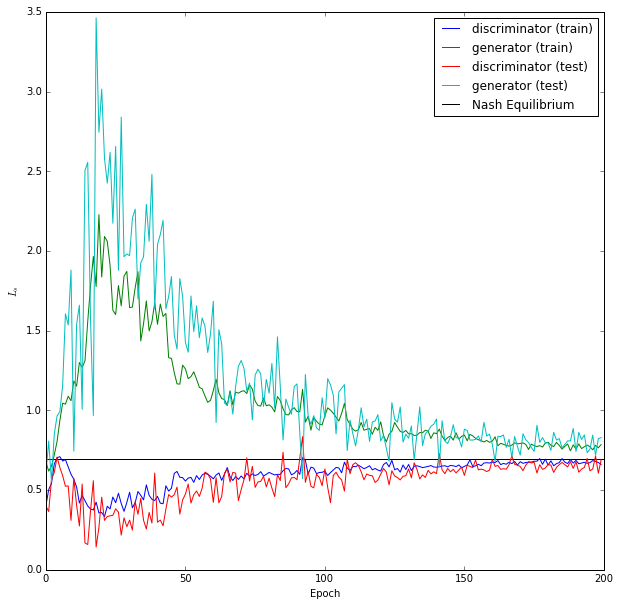

In [34]:
import h5py
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
plt.figure(figsize=(10,10))

hist = pkl.load(open(directory + 'acgan-history.pkl', 'rb'))
losses = ['loss', 'generation_loss', 'auxiliary_loss']

for p in ['train', 'test']:
    for g in ['discriminator', 'generator']:
        hist[p][g] = pd.DataFrame(hist[p][g], columns=losses)

for p in ['train', 'test']:
    for g in ['discriminator', 'generator']:
        plt.plot(hist[p][g]['generation_loss'], label='{} ({})'.format(g, p))

# get the NE and show as an equilibrium point
plt.hlines(-np.log(0.5), 0, hist[p][g]['generation_loss'].shape[0], label='Nash Equilibrium')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel(r'$L_s$')

plt.show()

# for p in hist['privacy']:
#     print(p)

In [13]:
print(hist['privacy'][-1])

IndexError: list index out of range

# Transfer Learning

In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

acgan = __import__('ac_gan')

from glob import glob
from keras.models import load_model

latent_size = 100

# for i in range(15, 30):
mean_scores = []
for i in range(0, 200):
    gen_name = sorted(glob(directory + 'params_generator*'))[-i]
    print(gen_name)
    g = load_model(gen_name)

    generate_count = training_size

    noise = np.random.uniform(-1, 1, (generate_count, latent_size))
    sampled_labels = np.random.randint(0, 2, generate_count)
    generated_images = g.predict([noise, sampled_labels.reshape((-1, 1))], verbose=0)

#     print(generated_images.shape)
    gen_X_train = np.reshape(generated_images, (training_size, 3, 12))

#     print(np.max(gen_X_train))
#     print(np.min(gen_X_train))

    for i in range(gen_X_train.shape[0]):
        gen_X_train[i][0] = gen_X_train[i][0] 
        gen_X_train[i][1] = gen_X_train[i][1] 
        gen_X_train[i][2] = gen_X_train[i][2]

    gen_X_train = gen_X_train.astype(int)
    gen_X_train = gen_X_train.clip(min=0)
#     print(gen_X_train[:2])
#     print(gen_X_train.shape)

    gen_X_train = gen_X_train.reshape(generate_count, -1)
#     print(gen_X_train.shape)

    gen_y_train = sampled_labels

    unique, counts = np.unique(y_train, return_counts=True)
#     print('real' + str(dict(zip(unique, counts))))

    unique, counts = np.unique(gen_y_train, return_counts=True)
#     print('gen' + str(dict(zip(unique, counts))))

#     print(gen_X_train.shape)
#     print(gen_y_train.shape)

    from sklearn.model_selection import cross_val_score

    transfer_clf = RandomForestClassifier()
    scores = cross_val_score(transfer_clf, gen_X_train, gen_y_train, cv=5)
    print(scores)

    score_list = []
    for i in range(5):
        gen_y_pred = transfer_clf.fit(gen_X_train, gen_y_train).predict(X_test)
        score_list.append(accuracy_score(y_test, gen_y_pred))
    print(score_list)
    print(np.mean(score_list))
    mean_scores.append(np.mean(score_list))

./output/privatenoaccount/params_generator_epoch_000.h5
[ 0.91507077  0.90416667  0.90083333  0.90166667  0.89241034]
[0.49203187250996017, 0.49203187250996017, 0.49203187250996017, 0.49203187250996017, 0.49203187250996017]
0.49203187251
./output/privatenoaccount/params_generator_epoch_199.h5
[ 0.99833472  0.99833472  1.          0.99916597  0.99916597]
[0.89043824701195218, 0.87051792828685259, 0.89243027888446214, 0.90039840637450197, 0.89243027888446214]
0.889243027888
./output/privatenoaccount/params_generator_epoch_198.h5
[ 0.99916736  1.          1.          1.          0.99916597]
[0.89043824701195218, 0.85657370517928288, 0.82071713147410363, 0.86254980079681276, 0.84063745019920322]
0.854183266932
./output/privatenoaccount/params_generator_epoch_197.h5
[ 0.99916736  0.9975      0.99833333  0.99666667  0.99833194]
[0.74302788844621515, 0.62749003984063745, 0.65537848605577687, 0.72509960159362552, 0.71513944223107573]
0.693227091633
./output/privatenoaccount/params_generator_ep

In [26]:
print(mean_scores)
print(max(mean_scores))
print(np.argmax(mean_scores))
print(mean_scores[58])

[0.49203187250996017, 0.8474103585657371, 0.81513944223107571, 0.85737051792828678, 0.79880478087649398, 0.85936254980079685, 0.78645418326693228, 0.88565737051792826, 0.82509960159362561, 0.88804780876494027, 0.88207171314741029, 0.87450199203187251, 0.79163346613545826, 0.59999999999999998, 0.77529880478087654, 0.61195219123505973, 0.82709163346613546, 0.72948207171314738, 0.8027888446215139, 0.83784860557768925, 0.62828685258964145, 0.61354581673306774, 0.7673306772908367, 0.72231075697211156, 0.84063745019920311, 0.80796812749003988, 0.88844621513944211, 0.85577689243027888, 0.85537848605577693, 0.86414342629482077, 0.84422310756972119, 0.85936254980079685, 0.68047808764940232, 0.83027888446215137, 0.85856573705179284, 0.80358565737051779, 0.80717131474103587, 0.83545816733067735, 0.81075697211155384, 0.77729083665338639, 0.63745019920318724, 0.6525896414342629, 0.84661354581673309, 0.86733067729083668, 0.88446215139442219, 0.83466135458167334, 0.73027888446215139, 0.74661354581673

In [30]:
gen_name = sorted(glob(directory + 'params_generator*'))[142]
print(gen_name)
g = load_model(gen_name)

generate_count = training_size

noise = np.random.uniform(-1, 1, (generate_count, latent_size))
sampled_labels = np.random.randint(0, 2, generate_count)
generated_images = g.predict([noise, sampled_labels.reshape((-1, 1))], verbose=0)

#     print(generated_images.shape)
gen_X_train = np.reshape(generated_images, (training_size, 3, 12))

#     print(np.max(gen_X_train))
#     print(np.min(gen_X_train))

for i in range(gen_X_train.shape[0]):
    gen_X_train[i][0] = gen_X_train[i][0] 
    gen_X_train[i][1] = gen_X_train[i][1] 
    gen_X_train[i][2] = gen_X_train[i][2]

gen_X_train = gen_X_train.astype(int)
gen_X_train = gen_X_train.clip(min=0)
#     print(gen_X_train[:2])
#     print(gen_X_train.shape)

gen_X_train = gen_X_train.reshape(generate_count, -1)
#     print(gen_X_train.shape)

gen_y_train = sampled_labels

unique, counts = np.unique(y_train, return_counts=True)
#     print('real' + str(dict(zip(unique, counts))))

unique, counts = np.unique(gen_y_train, return_counts=True)
#     print('gen' + str(dict(zip(unique, counts))))

#     print(gen_X_train.shape)
#     print(gen_y_train.shape)

from sklearn.model_selection import cross_val_score

transfer_clf = RandomForestClassifier()
scores = cross_val_score(transfer_clf, gen_X_train, gen_y_train, cv=5)
print(scores)

score_list = []
for i in range(5):
    gen_y_pred = transfer_clf.fit(gen_X_train, gen_y_train).predict(X_test)
    score_list.append(accuracy_score(y_test, gen_y_pred))
print(score_list)
print(np.mean(score_list))

./output/public/params_generator_epoch_142.h5
[ 0.98917569  0.99250624  0.99083333  0.99332777  0.99499583]
[0.90438247011952189, 0.89840637450199201, 0.90438247011952189, 0.91633466135458164, 0.89840637450199201]
0.90438247012


# PCA plot

(12000, 36)
[ 0.43290791  0.13495978]


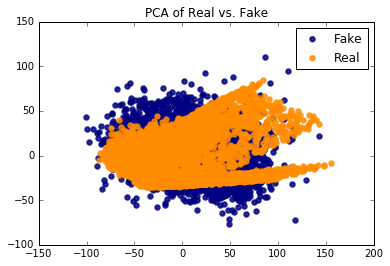

In [305]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

X_pca = np.concatenate((gen_X_train, X_train))
print(X_pca.shape)

y = np.array([1] * generate_count + [0] * training_size)
pca = PCA(n_components=2)
X_r = pca.fit(X_pca).transform(X_pca)

target_names = ['Fake', 'Real']
colors = ['navy', 'darkorange']
lw = 2

for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)

plt.title('PCA of Real vs. Fake')

print(pca.explained_variance_ratio_)

(1000, 36)


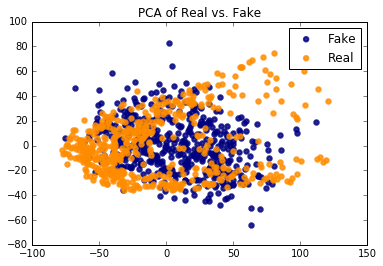

In [306]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

plot_count = 500
X_pca = np.concatenate((gen_X_train[:plot_count], X_train[:plot_count]))
print(X_pca.shape)

y = np.array([1] * plot_count + [0] * plot_count)

pca = PCA(n_components=2)
X_r = pca.fit(X_pca).transform(X_pca)

target_names = ['Fake', 'Real']
colors = ['navy', 'darkorange']
lw = 2

for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)

plt.title('PCA of Real vs. Fake')

# Real vs. Fake

In [298]:
clf =  RandomForestClassifier()

X_comb = np.concatenate((gen_X_train, X_train))
y = np.array([1] * generate_count + [0] * training_size)

print(X_comb.shape, y.shape)
scores = cross_val_score(clf, X_comb, y, cv=5)
print(scores)

from sklearn.neighbors import KNeighborsClassifier
nn_clf = KNeighborsClassifier(n_neighbors=9)

scores = cross_val_score(nn_clf, X_comb, y, cv=5)
print(scores)

((12000, 36), (12000,))
[ 0.99833333  0.9975      0.99791667  0.99583333  0.9975    ]
[ 0.97166667  0.96666667  0.96958333  0.97041667  0.97125   ]
